In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")


**Importing the Dataset**

In [2]:
dataset = pd.read_csv('creditcard.csv')

Exploring the Dataset

In [3]:
dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [4]:
print(dataset.shape)
# the size of dataset is quite large

(7973, 31)


In [5]:
print("Total Null values in the dataset:",dataset.isnull().sum().sum())
# there are no null values in the dataset

Total Null values in the dataset: 16


In [6]:
dataset.info()
# there are no categorical values in the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7973 entries, 0 to 7972
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    7973 non-null   int64  
 1   V1      7973 non-null   float64
 2   V2      7973 non-null   float64
 3   V3      7973 non-null   float64
 4   V4      7973 non-null   float64
 5   V5      7973 non-null   float64
 6   V6      7973 non-null   float64
 7   V7      7973 non-null   float64
 8   V8      7973 non-null   float64
 9   V9      7973 non-null   float64
 10  V10     7973 non-null   float64
 11  V11     7973 non-null   float64
 12  V12     7973 non-null   float64
 13  V13     7973 non-null   float64
 14  V14     7973 non-null   float64
 15  V15     7972 non-null   float64
 16  V16     7972 non-null   float64
 17  V17     7972 non-null   float64
 18  V18     7972 non-null   float64
 19  V19     7972 non-null   float64
 20  V20     7972 non-null   float64
 21  V21     7972 non-null   float64
 22  

In [7]:
# Checking for duplicate values in the dataset
duplicate_rows = dataset[dataset.duplicated()]
print("Number of duplicate rows: ", duplicate_rows.shape )

Number of duplicate rows:  (39, 31)


In [8]:
# removing the duplicate values
dataset = dataset.drop_duplicates()
print(dataset.shape)

(7934, 31)


In [9]:
dataset.describe()
# all the variables except Time and Amount are already scaled

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,7934.000000,7934.000000,7934.000000,7934.000000,7934.000000,7934.000000,7934.000000,7934.000000,7934.000000,7934.000000,7934.000000,7934.000000,7934.000000,7934.000000,7934.000000,7933.000000,7933.000000,7933.000000,7933.000000,7933.000000,7933.000000,7933.000000,7933.000000,7933.000000,7933.000000,7933.000000,7933.000000,7933.000000,7933.000000,7933.000000,7933.000000
mean,4265.866020,-0.295409,0.291666,0.900144,0.213070,-0.024998,0.153876,-0.024814,-0.070265,0.654957,-0.165567,0.639921,-1.028678,0.693317,0.563458,-0.065221,-0.031965,0.277632,-0.057377,-0.058320,0.043698,-0.056086,-0.164085,-0.035435,0.027775,0.088500,0.020956,0.016593,0.001389,65.632377,0.003151
std,3200.955972,1.496087,1.283142,1.091337,1.449013,1.168453,1.325629,1.063594,1.326226,1.157784,1.085120,1.130383,1.509627,1.238439,1.138244,0.982547,0.840226,0.851884,0.788932,0.808272,0.606706,0.944829,0.653324,0.489033,0.601026,0.428099,0.517899,0.402578,0.275971,195.349654,0.056052
min,0.000000,-23.066842,-25.640527,-12.389545,-4.657545,-32.092129,-7.574798,-12.968670,-23.632502,-3.878658,-7.454841,-2.595325,-10.912819,-3.389510,-11.736729,-4.152532,-7.552342,-12.598419,-5.131549,-4.932733,-13.276034,-11.468435,-8.527145,-15.144340,-2.512377,-2.577363,-1.338556,-7.976100,-3.054085,0.000000,0.000000
25%,1536.250000,-1.042173,-0.241813,0.373116,-0.694363,-0.629585,-0.659039,-0.514810,-0.199846,-0.087097,-0.674552,-0.164177,-2.277421,-0.208283,-0.050209,-0.649590,-0.540610,-0.259218,-0.502668,-0.548574,-0.147011,-0.271428,-0.578858,-0.183072,-0.337695,-0.161487,-0.363260,-0.062607,-0.019020,4.610000,0.000000
50%,3638.500000,-0.415461,0.333670,0.950339,0.219879,-0.107087,-0.153911,0.005093,0.015797,0.613351,-0.258819,0.627285,-1.061161,0.714736,0.566851,0.057907,0.026800,0.237187,-0.026693,-0.054235,-0.007288,-0.130326,-0.165010,-0.046031,0.090647,0.114822,-0.013842,0.006989,0.018440,15.950000,0.000000
75%,6678.250000,1.123771,0.947491,1.598349,1.128599,0.404302,0.545724,0.527343,0.304993,1.294024,0.242704,1.421102,0.299086,1.641855,1.401405,0.597824,0.521481,0.750077,0.417430,0.463965,0.173767,0.044641,0.250886,0.086787,0.421234,0.362178,0.328056,0.144228,0.080838,55.000000,0.000000
max,10981.000000,1.685314,8.261750,4.101716,7.380245,11.974269,21.393069,34.303177,3.877662,10.392889,12.259949,7.620089,3.774837,4.465413,5.748734,3.635042,4.087802,6.739384,3.042493,3.097749,8.012574,22.588989,4.534454,13.876221,3.200201,5.525093,3.517346,4.173387,4.860769,7712.430000,1.000000


In [10]:
print(dataset['Class'].value_counts())
# The number of fraud transactions is very less as compared to legit transactions

0.0    7908
1.0      25
Name: Class, dtype: int64


In [11]:
print('Legit Transactions:', round(dataset['Class'].value_counts()[0]/len(dataset) * 100,2),'%')
print('Frauds Transactions:', round(dataset['Class'].value_counts()[1]/len(dataset) * 100,2),'%')
# the classes are heavily skewed we need to solve this issue later

Legit Transactions: 99.67 %
Frauds Transactions: 0.32 %


Text(0.5, 1.0, 'Class Distributions \n (0: Legit, 1: Fraud)')

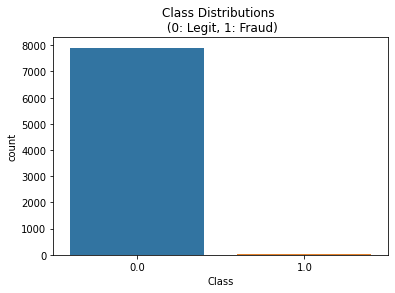

In [12]:
sns.countplot('Class', data=dataset)
plt.title('Class Distributions \n (0: Legit, 1: Fraud)')

In [13]:
# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount)
# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

dataset['scaled_amount'] = rob_scaler.fit_transform(dataset['Amount'].values.reshape(-1,1))
dataset.drop(['Amount'], axis=1, inplace=True)

In [14]:
scaled_amount = dataset['scaled_amount']

dataset.drop(['scaled_amount'], axis=1, inplace=True)
dataset.insert(0, 'scaled_amount', scaled_amount)

dataset.head()

,scaled_amount,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,2.652709,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.0
1,-0.263147,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0.0
2,7.198055,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0.0
3,2.134352,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.0
4,1.072435,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.0


**Extracting independent and dependent variables**

In [15]:
x = dataset.drop(['Time','Class'], axis=1)
y = dataset['Class']

**Creating a Subsample**

Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes. For that we are going to create a subsample from our dataset, i.e., we will take a small number(equal to the number of fraud transactions) of Legit transaction and combine them with fraud transactions. So that our subsample will have equal number of legit and fraud transactions and out model will trian correctly. We'll shuffle the data before creating the subsample.

In [16]:
dataset = dataset.sample(frac=1)

fraud_dataset = dataset.loc[dataset['Class'] == 1]                            # Extracting fraud transactions
legit_dataset = dataset.loc[dataset['Class'] == 0][:473]                      # Amount of fraud transactions is 473.

normal_distributed_dataset = pd.concat([fraud_dataset, legit_dataset])        # Combining Legit and Fraud Transactions

new_dataset = normal_distributed_dataset.sample(frac=1, random_state=42)      # Shuffling dataframe rows

new_dataset.head()                                                            # The subsample we wanted

,scaled_amount,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
6365,0.397896,7580,-1.336230,1.865051,1.978868,0.978849,-0.234387,0.397032,0.129588,-2.889022,1.700077,1.307131,2.498086,-2.483602,0.503042,1.306001,0.140434,-0.240762,0.285354,0.942457,0.546195,0.038317,1.948459,-0.758797,0.185097,0.388893,-0.319203,-0.501493,0.231347,-0.340135,0.0
4047,0.106172,3700,1.180420,0.323488,0.519571,1.137240,-0.131787,-0.308910,-0.101540,-0.089240,1.128113,-0.215285,1.980780,-1.727022,1.606024,1.943220,-0.363454,0.469188,-0.119859,0.716150,-0.166892,-0.128847,-0.183891,-0.335746,-0.056450,-0.068835,0.490884,-0.501911,-0.010127,0.009858,0.0
236,-0.118079,156,1.325295,-1.138678,1.276266,-0.207920,-1.642088,0.696573,-1.502955,0.297740,0.872381,0.251926,-2.332011,0.047517,-0.033914,-1.266317,-1.605192,-1.743712,0.482655,0.997654,0.221744,-0.498397,-0.606348,-0.803193,-0.026618,-0.397273,0.245699,1.127406,0.023011,0.012264,0.0
5254,0.225243,5091,-1.996657,0.633842,2.007773,3.139770,0.212306,0.576402,-0.186588,0.196046,-0.040092,0.883099,2.596288,-1.710568,2.622838,1.491105,0.324251,0.059684,0.642519,0.593015,0.372979,-0.577956,0.022916,0.992860,0.513728,0.213372,-0.240347,0.240536,-0.428266,-0.224549,0.0
323,-0.174836,236,-0.438337,1.028364,1.455502,-0.230275,0.198899,-0.358325,0.659133,0.059988,-0.741863,-0.167486,1.123057,0.906575,0.717446,0.177484,0.094042,0.459450,-0.805970,0.165908,0.422938,0.173605,-0.187516,-0.485442,-0.074138,-0.002586,-0.153928,0.071891,0.264233,0.109265,0.0


In [17]:
new_dataset.shape
# the subsample is relatively smaller than our original dataset but equally distributed.

(498, 31)

Distribution of the Classes in the subsample dataset
0.0    0.949799
1.0    0.050201
Name: Class, dtype: float64


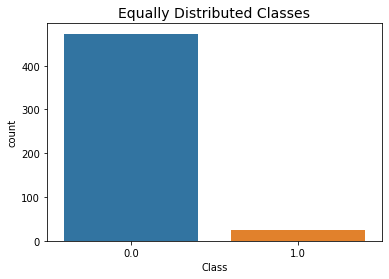

In [18]:
print('Distribution of the Classes in the subsample dataset')
print(new_dataset['Class'].value_counts()/len(new_dataset))

sns.countplot('Class', data=new_dataset)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

**Heatmap of original dataset**

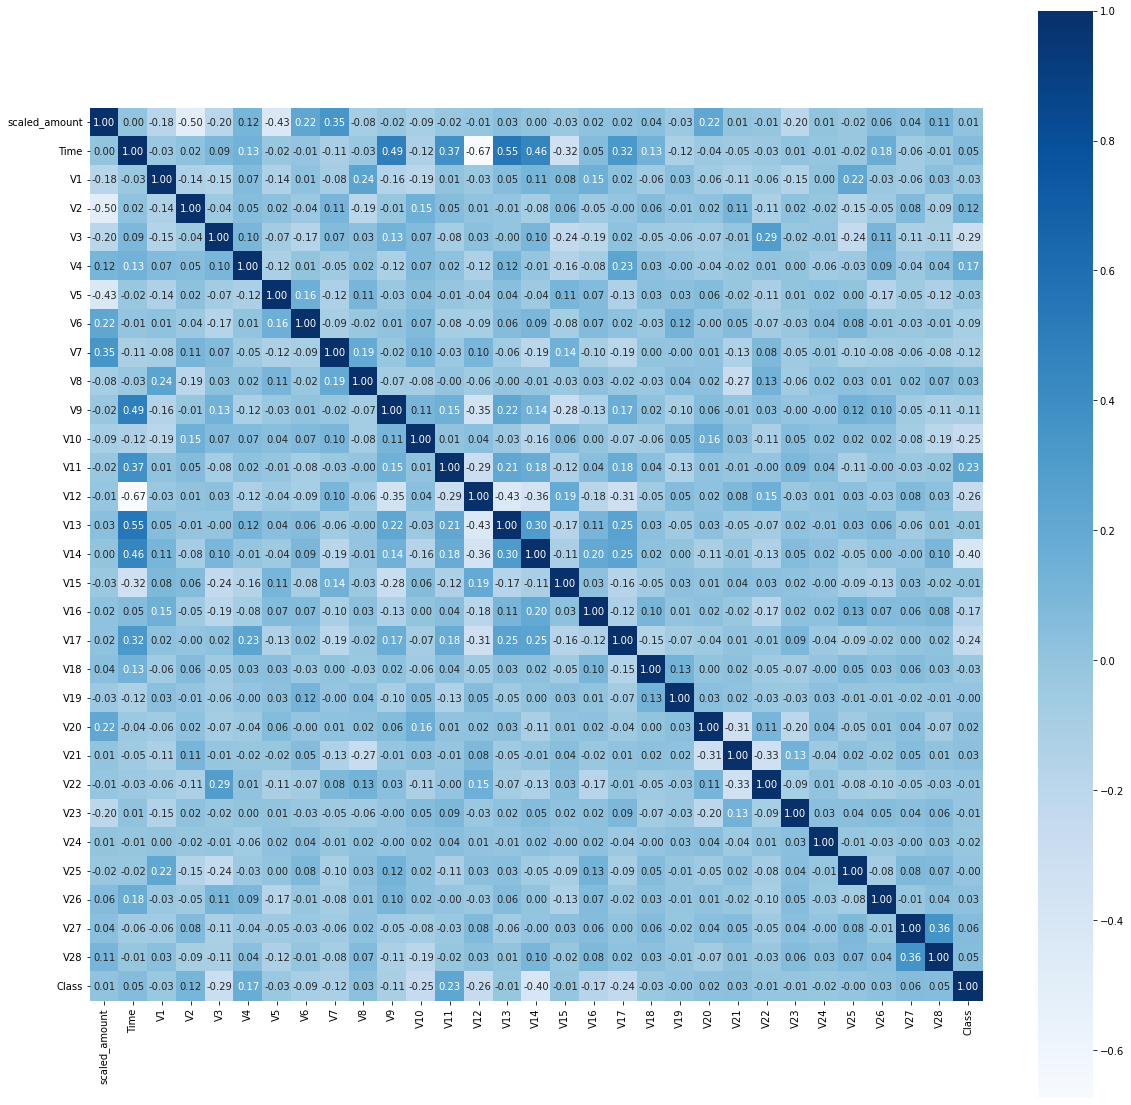

In [19]:
plt.subplots(figsize=(20,20))
sns.heatmap(dataset.corr(), cbar=True, square=True, fmt='.2f', annot=True, annot_kws = {'size':10}, cmap='Blues')
# as we can see all the independent variables have a little correlation with Class.


**Heatmap of Subsample**

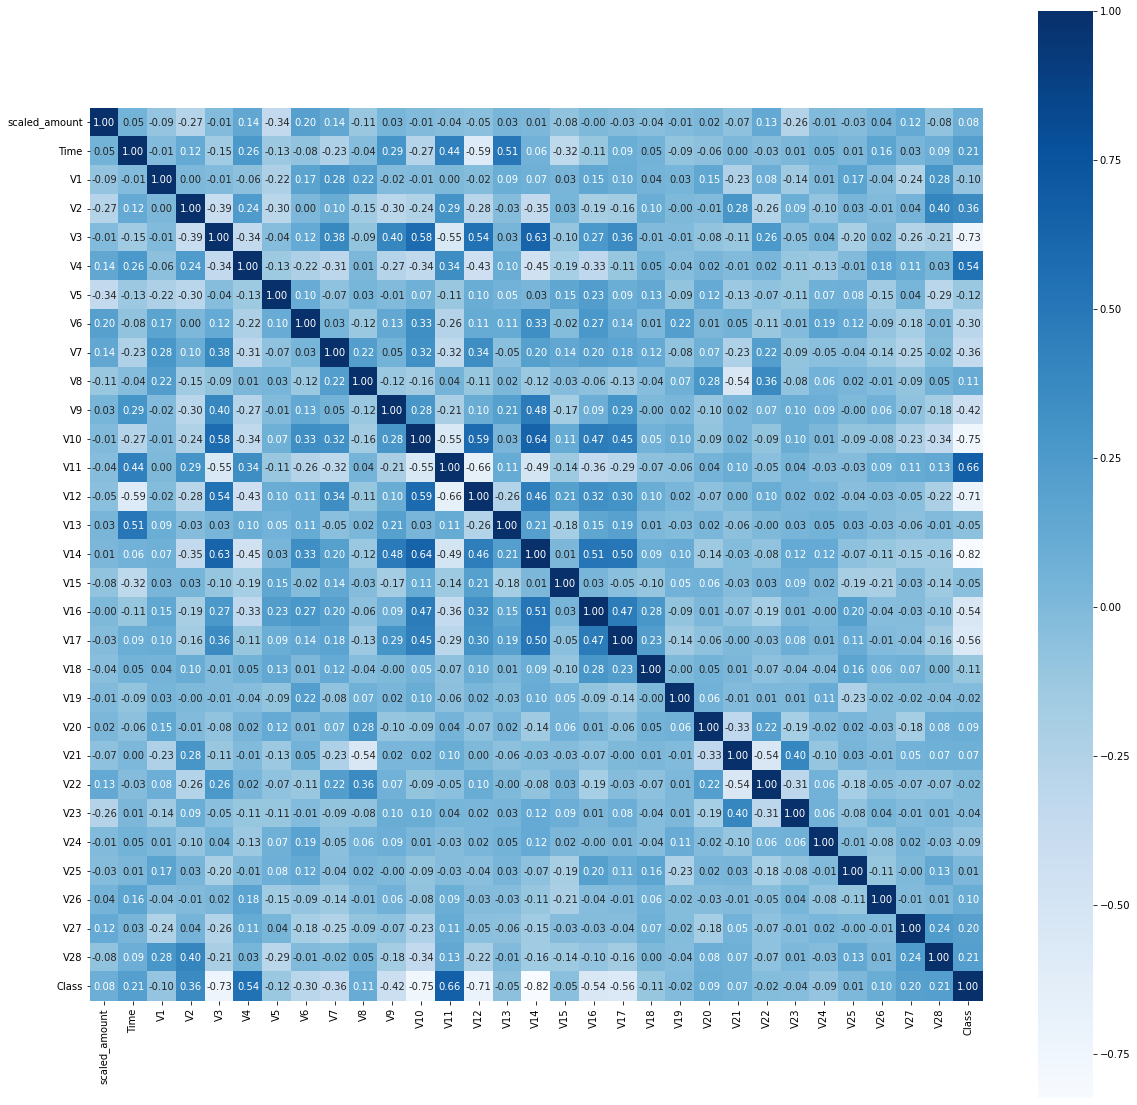

In [20]:
plt.subplots(figsize=(20,20))
sns.heatmap(new_dataset.corr(), cbar=True, square=True, fmt='.2f', annot=True, annot_kws = {'size':10}, cmap='Blues')
# as we can see now there is high correlation of independent variables with Class.

**Splitting the dataset into traning and test data**

In [21]:
x = new_dataset.drop(['Time', 'Class'], axis=1)
y = new_dataset['Class']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(x_train.shape, x_test.shape)

(398, 29) (100, 29)


Applying Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

**Accuracy Score**

In [23]:
y_pred = model.predict(x_test)
print("Accuracy score:",(round(accuracy_score(y_test, y_pred)*100, 2)),'%')

Accuracy score: 99.0 %


**Confusion Matix**

[Text(0, 0.5, ''), Text(0, 1.5, '')]

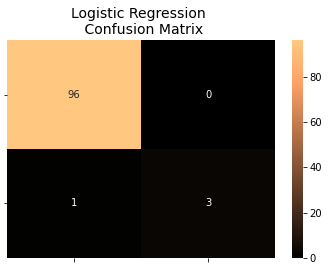

In [24]:
log_reg_cf = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(log_reg_cf, annot=True, cmap=plt.cm.copper)
ax.set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax.set_xticklabels(['', ''], fontsize=14, rotation=90)
ax.set_yticklabels(['', ''], fontsize=14, rotation=360)

**Classification Report**

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99        96
         1.0       1.00      0.75      0.86         4

    accuracy                           0.99       100
   macro avg       0.99      0.88      0.93       100
weighted avg       0.99      0.99      0.99       100



**Creating a test case**

In [26]:
test_case_list = [239.93, -2.303349568, 1.75924746, -0.359744743, 2.330243051, -0.821628328, -0.075787571, 0.562319782, -0.399146578, -0.238253368, -1.525411627, 2.032912158, -6.560124295, 0.022937323, -1.470101536, -0.698826069, -2.282193829, -4.781830856, -2.615664945, -1.334441067, -0.430021867, -0.294166318, -0.932391057, 0.172726296, -0.087329538, -0.156114265, -0.542627889, 0.039565989, -0.153028797]

test_case_df = pd.DataFrame(test_case_list)               # converting the list into a dataframe
test_case = test_case_df.T                                # the shape of current df is (11,1) and the required shape is (1,11)
test_case_prediction = model.predict(test_case)           # predicting the quality for test case
if(test_case_prediction == 0):                            # generating the result.
    print('The Transaction was Legit')
else:
    print('The Transaction was Fraud.')

The Transaction was Fraud.
